## Import libs

In [1]:
from math import sqrt, isnan
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from util import metrics
from util.load_data import load_data
from util.evaluation import *

from zhang.models import FairLogisticRegression
from zhang.learning import *

## Preliminaries

In [2]:
batch_size = 64
epochs = 10
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate)

## Load data

In [3]:
x_train, y_train, a_train = load_data('adult', 'train')
raw_data = (x_train, y_train, a_train)

In [4]:
xdim = x_train.shape[1]
ydim = y_train.shape[1]
adim = a_train.shape[1]

In [5]:
train_data = Dataset.from_tensor_slices((x_train, y_train, a_train))
train_data = train_data.batch(batch_size, drop_remainder=True)
train_data

<BatchDataset shapes: ((64, 112), (64, 1), (64, 1)), types: (tf.float64, tf.float64, tf.float64)>

In [6]:
x_valid, y_valid, a_valid = load_data('adult', 'valid')

valid_data = Dataset.from_tensor_slices((x_valid, y_valid, a_valid))
valid_data = valid_data.batch(batch_size, drop_remainder=True)

In [7]:
x_test, y_test, a_test = load_data('adult', 'test')

test_data = Dataset.from_tensor_slices((x_test, y_test, a_test))
test_data = test_data.batch(batch_size, drop_remainder=True)

## Testing if models are being trained

### For DP

In [8]:
fairdef='DemPar'
model = FairLogisticRegression(xdim, batch_size, fairdef)

ret = train_loop(model, raw_data, train_data, 1)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.537175178527832 | 0.8347809910774231 | 0.6528514588859416 | 0.3241462201591512


In [9]:
Y, A, Y_hat, A_hat = evaluation(model, valid_data)
ret = compute_metrics(Y, A, Y_hat, A_hat)

> Class Acc | Adv Acc
> 0.8068484042553191 | 0.32563164893617025
> DP | DEqOdds | DEqOpp
> 0.8780761063098907 | 0.8350172247737646 | 0.7082487344741821
> Confusion Matrix 
TN: 4451.0 | FP: 107.0 
FN: 1055.0 | TP: 403.0
> Confusion Matrix for A = 0 
TN: 1758.0 | FP: 0.0 
FN: 196.0 | TP: 5.0
> Confusion Matrix for A = 1 
TN: 2693.0 | FP: 107.0 
FN: 859.0 | TP: 398.0


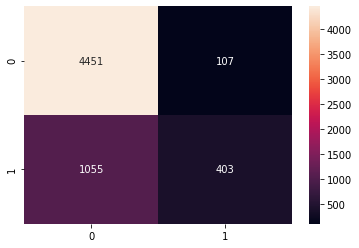

In [10]:
sns.heatmap(ret[4], annot=True, fmt='g')

### For EqOdds

In [11]:
fairdef='EqOdds'
model = FairLogisticRegression(xdim, batch_size, fairdef)
ret = train_loop(model, raw_data, train_data, 1)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.5167679786682129 | 0.7780622243881226 | 0.6641661140583555 | 0.32418766578249336


In [12]:
Y, A, Y_hat, A_hat = evaluation(model, valid_data)
ret = compute_metrics(Y, A, Y_hat, A_hat)

> Class Acc | Adv Acc
> 0.8228058510638298 | 0.3272938829787234
> DP | DEqOdds | DEqOpp
> 0.7855367064476013 | 0.7250424064695835 | 0.5398069024085999
> Confusion Matrix 
TN: 4299.0 | FP: 259.0 
FN: 807.0 | TP: 651.0
> Confusion Matrix for A = 0 
TN: 1755.0 | FP: 3.0 
FN: 191.0 | TP: 10.0
> Confusion Matrix for A = 1 
TN: 2544.0 | FP: 256.0 
FN: 616.0 | TP: 641.0


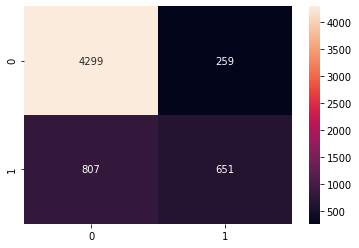

In [13]:
sns.heatmap(ret[4], annot=True, fmt='g')

### For EqOpp

In [14]:
fairdef='EqOpp'
model = FairLogisticRegression(xdim, batch_size, fairdef)
ret = train_loop(model, raw_data, train_data, 1)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.5352369546890259 | 0.3454836308956146 | 0.6534316976127321 | 0.3241462201591512


In [15]:
Y, A, Y_hat, A_hat = evaluation(model, valid_data)
ret = compute_metrics(Y, A, Y_hat, A_hat)

> Class Acc | Adv Acc
> 0.8093417553191489 | 0.32563164893617025
> DP | DEqOdds | DEqOpp
> 0.8781635612249374 | 0.8410549741238356 | 0.7193982601165771
> Confusion Matrix 
TN: 4451.0 | FP: 107.0 
FN: 1040.0 | TP: 418.0
> Confusion Matrix for A = 0 
TN: 1757.0 | FP: 1.0 
FN: 192.0 | TP: 9.0
> Confusion Matrix for A = 1 
TN: 2694.0 | FP: 106.0 
FN: 848.0 | TP: 409.0


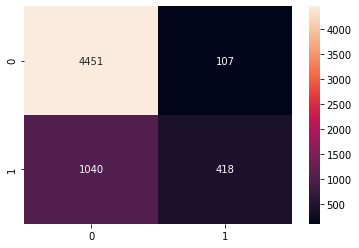

In [16]:
sns.heatmap(ret[4], annot=True, fmt='g')

## Models

In [17]:
cmap = sns.light_palette("seagreen", as_cmap=True)

In [18]:
#For DemPar
fairdef = 'DemPar'
model = FairLogisticRegression(xdim, batch_size, fairdef)
train_loop(model, raw_data, train_data, epochs)
print('Validation')
Y, A, Y_hat, A_hat = evaluation(model, valid_data)
ret4dp = compute_metrics(Y, A, Y_hat, A_hat)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.537175178527832 | 0.8347809910774231 | 0.6528514588859416 | 0.3241462201591512
> 2 | 0.49111971259117126 | 0.7466696500778198 | 0.8116296419098143 | 0.3260941644562334
> 3 | 0.4756799340248108 | 0.7003680467605591 | 0.8230686339522546 | 0.42892075596816975
> 4 | 0.4695778489112854 | 0.6720441579818726 | 0.8257211538461539 | 0.5442224801061007
> 5 | 0.4664961099624634 | 0.6524231433868408 | 0.8274618700265252 | 0.6349883952254642
> 6 | 0.46467870473861694 | 0.6377593278884888 | 0.8284565649867374 | 0.6802055702917772
> 7 | 0.463444322347641 | 0.6268690824508667 | 0.8294927055702918 | 0.6962035809018567
> 8 | 0.4625151455402374 | 0.6181811094284058 | 0.8307360742705571 | 0.7015500663129973
> 9 | 0.46182018518447876 | 0.6109867095947266 | 0.8312748673740054 | 0.7056946286472149
> 10 | 0.46129101514816284 | 0.6049099564552307 | 0.8319794429708223 | 0.7053630636604774
Validation
> Class Acc | Adv Acc
> 0.8342752659574468 | 0.7086

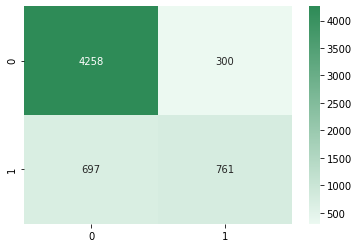

In [19]:
sns.heatmap(ret4dp[4], cmap=cmap, annot=True, fmt='g')

In [20]:
#For EqOdds
fairdef = 'EqOdds'
model = FairLogisticRegression(xdim, batch_size, fairdef)
train_loop(model, raw_data, train_data, epochs)
print('Validation')
Y, A, Y_hat, A_hat = evaluation(model, valid_data)
ret4eqodds = compute_metrics(Y, A, Y_hat, A_hat)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.5167679786682129 | 0.7780622243881226 | 0.6641661140583555 | 0.32418766578249336
> 2 | 0.4772248864173889 | 0.6772430539131165 | 0.8168932360742706 | 0.4421004641909814
> 3 | 0.46702659130096436 | 0.6287922859191895 | 0.8217009283819628 | 0.635195623342175
> 4 | 0.4633764922618866 | 0.6006664633750916 | 0.8241462201591512 | 0.6976127320954907
> 5 | 0.4616450369358063 | 0.5816541910171509 | 0.8262599469496021 | 0.7116213527851459
> 6 | 0.460674524307251 | 0.567629337310791 | 0.8277519893899205 | 0.7141909814323607
> 7 | 0.4600658416748047 | 0.5567131042480469 | 0.8287052387267905 | 0.7152685676392573
> 8 | 0.4596503973007202 | 0.5479137897491455 | 0.8291611405835544 | 0.7156001326259946
> 9 | 0.45930930972099304 | 0.541719913482666 | 0.8296584880636605 | 0.7158902519893899
> 10 | 0.45897865295410156 | 0.536864161491394 | 0.8304459549071618 | 0.7161389257294429
Validation
> Class Acc | Adv Acc
> 0.8326130319148937 | 0.71742021

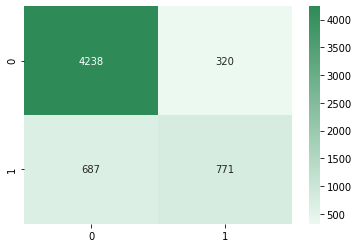

In [21]:
sns.heatmap(ret4eqodds[4], cmap=cmap, annot=True, fmt='g')

In [22]:
#For EqOpp
fairdef = 'EqOpp'
model = FairLogisticRegression(xdim, batch_size, fairdef)
train_loop(model, raw_data, train_data, epochs)
print('Validation')
Y, A, Y_hat, A_hat = evaluation(model, valid_data)
ret4eqopp = compute_metrics(Y, A, Y_hat, A_hat)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.5352369546890259 | 0.3454836308956146 | 0.6534316976127321 | 0.3241462201591512
> 2 | 0.4896917939186096 | 0.28298279643058777 | 0.81345324933687 | 0.36849303713527853
> 3 | 0.4740065634250641 | 0.2508600652217865 | 0.8228199602122016 | 0.4504310344827586
> 4 | 0.46769219636917114 | 0.23284979164600372 | 0.8252238063660478 | 0.4923740053050398
> 5 | 0.46450501680374146 | 0.22145062685012817 | 0.8267572944297082 | 0.5184847480106101
> 6 | 0.46264076232910156 | 0.21360230445861816 | 0.8279592175066313 | 0.533612400530504
> 7 | 0.46144241094589233 | 0.2078699767589569 | 0.8288710212201591 | 0.5444711538461539
> 8 | 0.4606204628944397 | 0.20349963009357452 | 0.8299486074270557 | 0.5502320954907162
> 9 | 0.4600295424461365 | 0.2000572681427002 | 0.8307775198938993 | 0.5560344827586207
> 10 | 0.45958954095840454 | 0.1972757875919342 | 0.8312334217506632 | 0.5620026525198939
Validation
> Class Acc | Adv Acc
> 0.8344414893617021 | 0

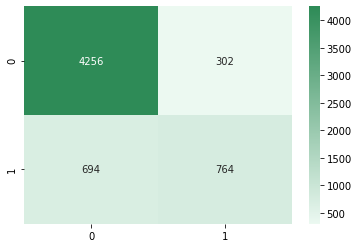

In [23]:
sns.heatmap(ret4eqopp[4], cmap=cmap, annot=True, fmt='g')

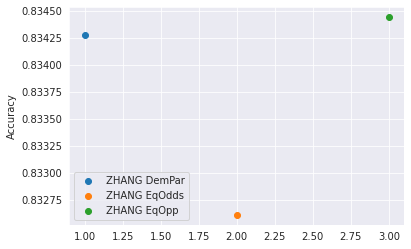

In [24]:
#x=[1,2,3]
#y = [tf.math.reduce_mean(ret4dp[0]),tf.math.reduce_mean(ret4eqodds[0]),tf.math.reduce_mean(ret4eqodds[0])]
y=[2,4,6]
#plt.scatter()
#plt.pyplot.grid(b=True, color='darkgrey')
sns.set_style('darkgrid')
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(fair_coeff_list, laftr_accs, label = "laftr")
# line 2 points'''

# plotting the line 2 points 
#plt.scatter(x, y)

plt.scatter(1, ret4dp[0], label = "ZHANG DemPar")

plt.scatter(2, ret4eqodds[0], label = "ZHANG EqOdds")

plt.scatter(3, ret4eqopp[0], label = "ZHANG EqOpp")

#plt.xlabel('Fair coefficient')
plt.legend()

plt.show()

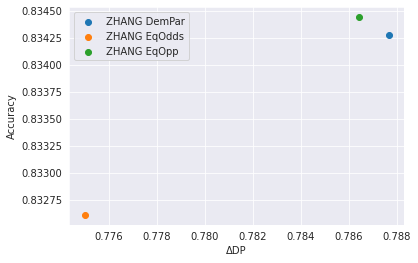

In [25]:
plt.plot()
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(fair_coeff_list, laftr_dps, label = "laftr")
# line 2 points'''
#axes = plt.gca()
#axes.set_xlim([0.0643,0.0645])
plt.scatter(ret4dp[1], ret4dp[0], label = "ZHANG DemPar")

plt.scatter(ret4eqodds[1], ret4eqodds[0], label = "ZHANG EqOdds")

plt.scatter(ret4eqopp[1], ret4eqopp[0], label = "ZHANG EqOpp")

plt.xlabel('\u0394DP')
plt.legend()
plt.show()

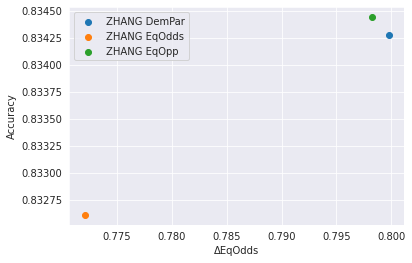

In [26]:
plt.plot()
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(fair_coeff_list, laftr_dps, label = "laftr")
# line 2 points'''

plt.scatter(ret4dp[2], ret4dp[0], label = "ZHANG DemPar")

plt.scatter(ret4eqodds[2], ret4eqodds[0], label = "ZHANG EqOdds")

plt.scatter(ret4eqopp[2], ret4eqopp[0], label = "ZHANG EqOpp")

plt.xlabel('\u0394EqOdds')
plt.legend()
plt.show()

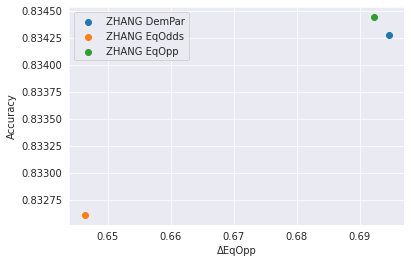

In [27]:
plt.plot()
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(fair_coeff_list, laftr_dps, label = "laftr")
# line 2 points'''

plt.scatter(ret4dp[3], ret4dp[0], label = "ZHANG DemPar")

plt.scatter(ret4eqodds[3], ret4eqodds[0], label = "ZHANG EqOdds")

plt.scatter(ret4eqopp[3], ret4eqopp[0], label = "ZHANG EqOpp")

plt.xlabel('\u0394EqOpp')
plt.legend()
plt.show()